# **Needed Libraries**

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


2024-09-19 06:05:36.700680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 06:05:36.700848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 06:05:36.836856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Reading the Data**

In [2]:
train_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
img_paths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        img_paths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(img_paths, name= 'img_paths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
train_df 

img_paths     labels
0     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
1     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
2     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
3     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
4     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
...                                                 ...        ...
2632  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2633  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2634  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2635  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2636  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant

[2637 rows x 2 columns]

In [4]:
train_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
img_paths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        img_paths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(img_paths, name= 'img_paths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
test_df

img_paths     labels
0     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
1     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
2     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
3     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
4     /kaggle/input/skin-cancer-malignant-vs-benign/...     benign
...                                                 ...        ...
2632  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2633  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2634  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2635  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant
2636  /kaggle/input/skin-cancer-malignant-vs-benign/...  malignant

[2637 rows x 2 columns]

# **Preprocessing**

In [6]:
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [7]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'img_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'img_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'img_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 1318 validated image filenames belonging to 2 classes.
Found 1319 validated image filenames belonging to 2 classes.


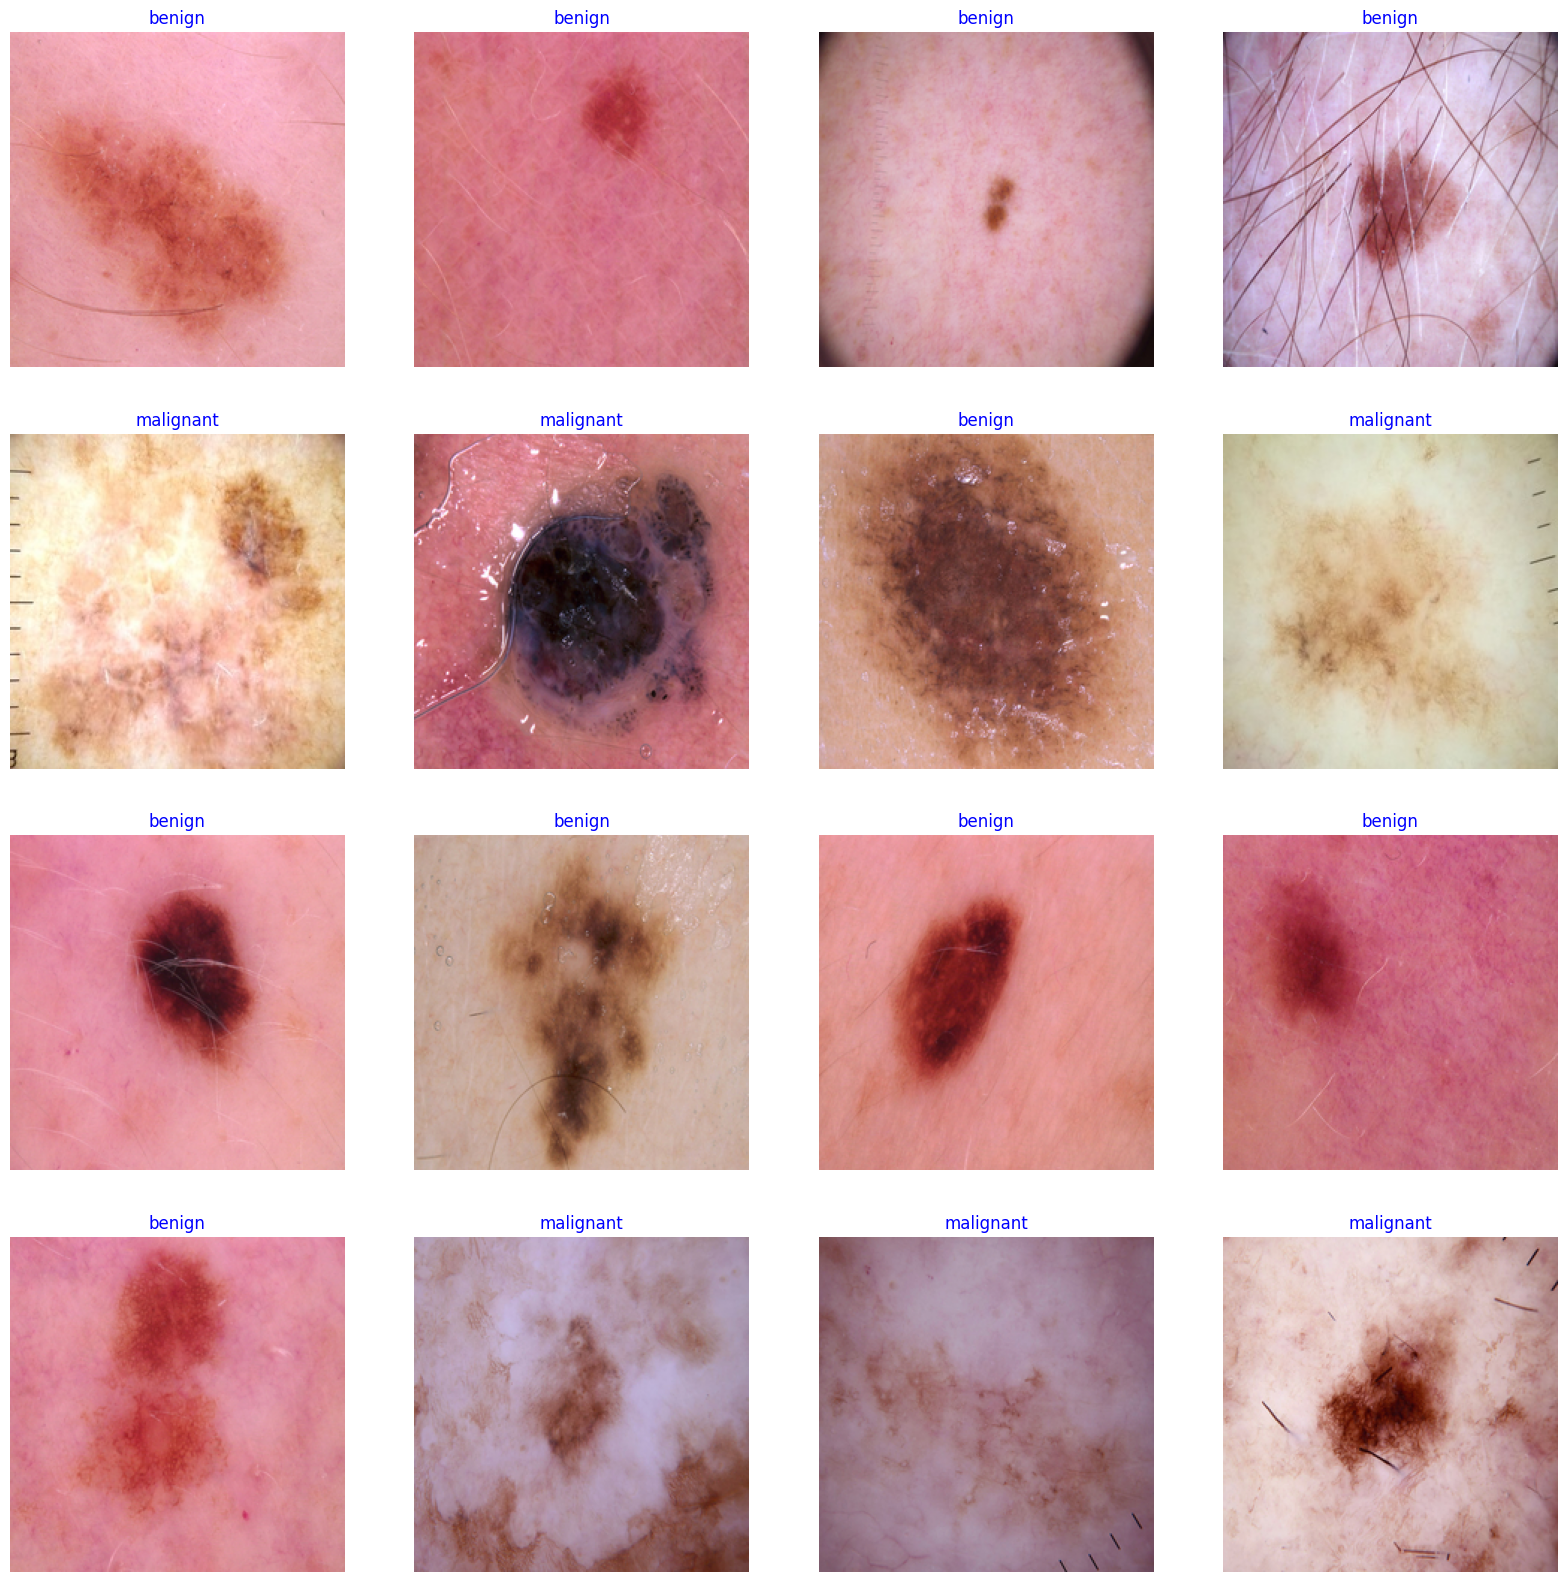

In [8]:
# sample of train data

g_dict = train_gen.class_indices       
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

# **Modeling Using EfficientNetB3**

In [9]:
from tensorflow.keras.applications import EfficientNetB3

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'avg')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.build(input_shape=(None, *img_shape))
model.summary()




16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [10]:
history = model.fit(x= train_gen, epochs= 10, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)


Epoch 1/10
  3/165 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5625 - loss: 19.1903    

I0000 00:00:1726725987.697757      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1726725987.753543      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7231 - loss: 13.9381

W0000 00:00:1726726030.196210      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/165 ━━━━━━━━━━━━━━━━━━━━ 85s 315ms/step - accuracy: 0.7233 - loss: 13.9191 - val_accuracy: 0.7172 - val_loss: 5.5336
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7854 - loss: 5.5781 - val_accuracy: 0.6778 - val_loss: 4.2990
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7470 - loss: 4.0788 - val_accuracy: 0.6998 - val_loss: 3.3038
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.6790 - loss: 3.1048 - val_accuracy: 0.7286 - val_loss: 2.4976
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7230 - loss: 2.3315 - val_accuracy: 0.7703 - val_loss: 1.8730
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7068 - loss: 1.7841 - val_accuracy: 0.7923 - val_loss: 1.4281
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7174 - loss: 1.3797 - val_accuracy: 0.8180 - val_loss: 1.1158
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7389 - loss: 1.1109 - val_accura

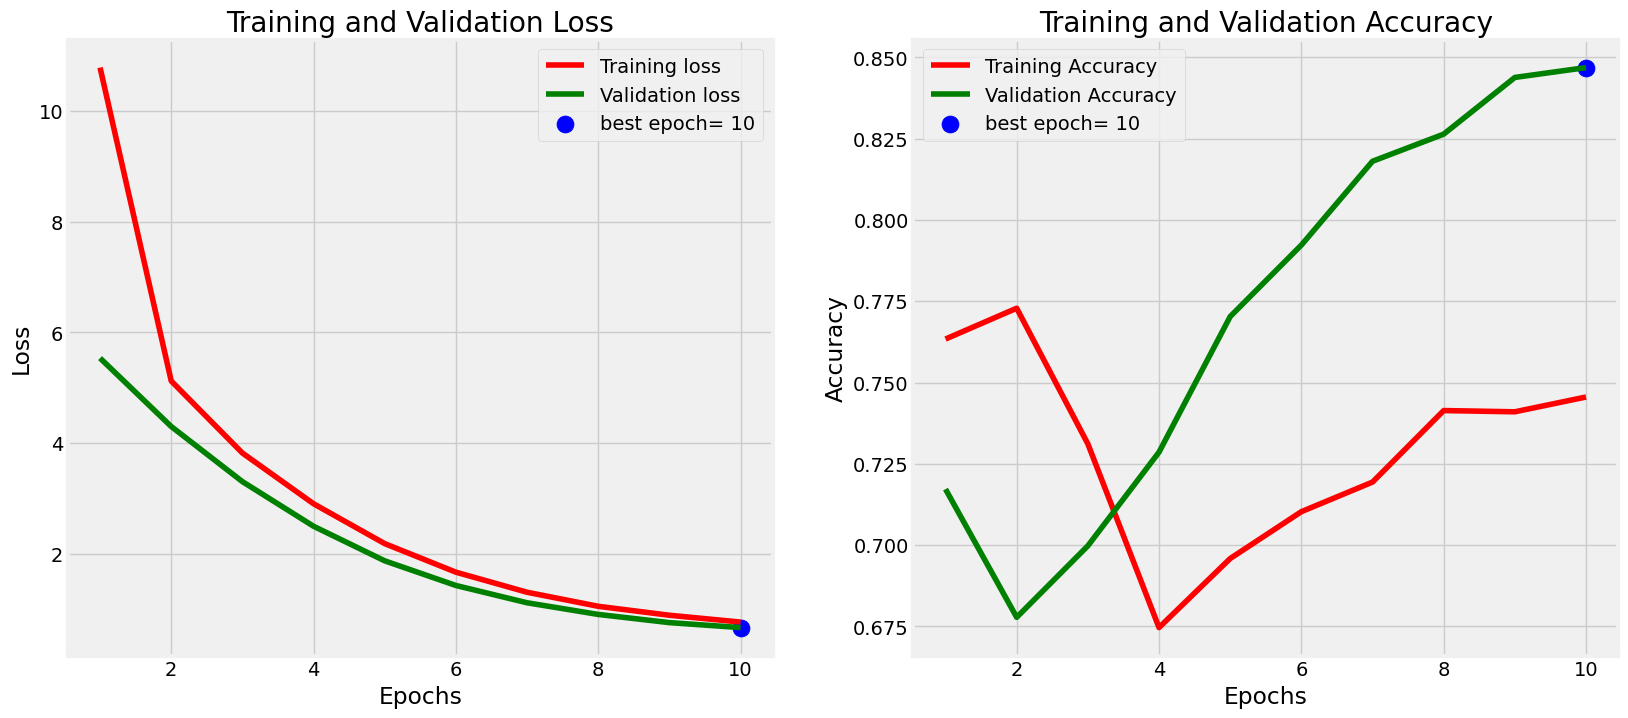

In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

**Evaluate Model**

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps)
valid_score = model.evaluate(valid_gen, steps= test_steps)
test_score = model.evaluate(test_gen, steps= test_steps)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8488 - loss: 0.6628  
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8507 - loss: 0.6577    
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8471 - loss: 0.6681  
Train Loss:  0.6626428365707397
Train Accuracy:  0.8494501113891602
--------------------
Validation Loss:  0.6570204496383667
Validation Accuracy:  0.8520485758781433
--------------------
Test Loss:  0.6677863001823425
Test Accuracy:  0.8468536734580994


**Predictions**

In [13]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 5/83 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

W0000 00:00:1726726157.839368      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step


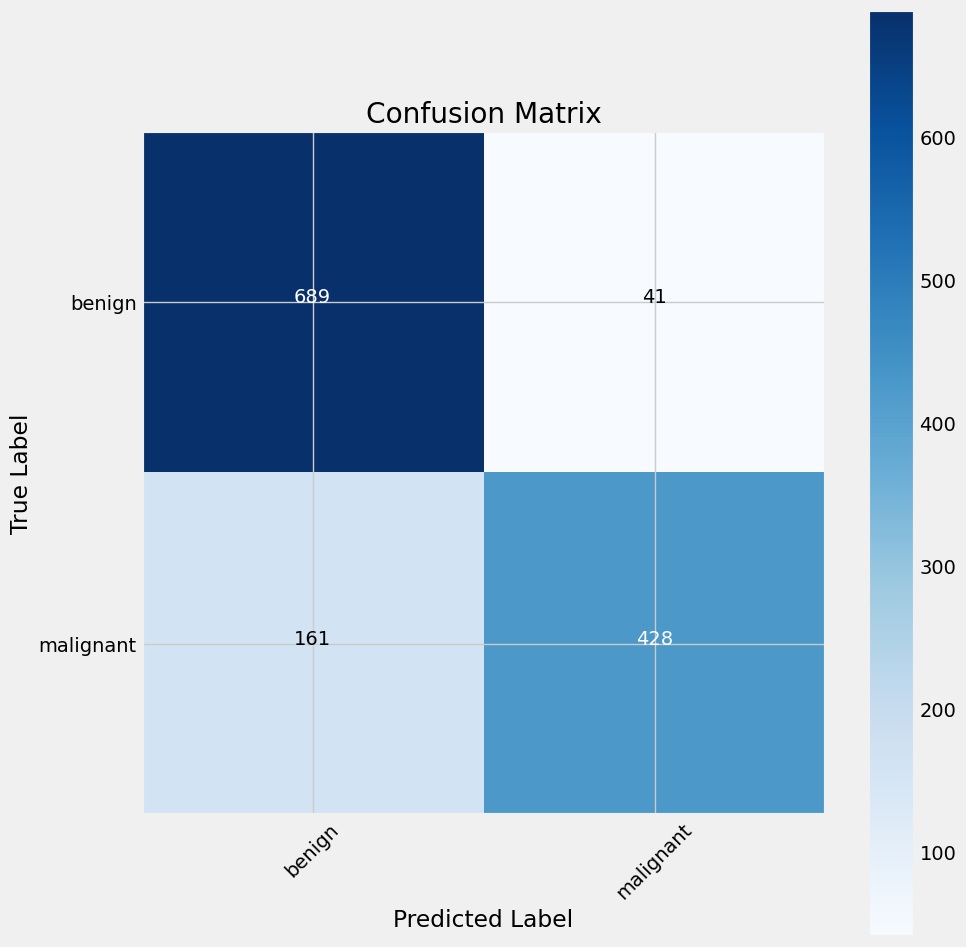

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.81      0.94      0.87       730
   malignant       0.91      0.73      0.81       589

    accuracy                           0.85      1319
   macro avg       0.86      0.84      0.84      1319
weighted avg       0.86      0.85      0.84      1319



# **Modeling Using ResNet50**

In [16]:
from tensorflow.keras.applications import ResNet50


img_size_resnet = (224, 224)
channels_resnet = 3
img_shape_resnet = (img_size_resnet[0], img_size_resnet[1], channels_resnet)

# Number of classes in your dataset
class_count_resnet = len(list(train_gen.class_indices.keys()))

# Create pre-trained ResNet50 model
base_model_resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape_resnet,
    pooling='avg'  # Using average pooling to reduce spatial dimensions
)
base_model_resnet.trainable = False  # Freeze the base model weights

# Build the Sequential model
model_resnet = Sequential([
    base_model_resnet,
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.016), 
                 activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006)),
    layers.Dropout(0.45),
    layers.Dense(class_count_resnet, activation='softmax')
])

# Compile the model
model_resnet.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model (this is necessary for defining the input shape)
model_resnet.build(input_shape=(None, *img_shape_resnet))

# Print model summary
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,120,962 (92.01 MB)

 Trainable params: 529,154 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [17]:
history_resnet = model_resnet.fit( x=train_gen, epochs=10, verbose=1, validation_data=test_gen,validation_steps=None, shuffle=False)


Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.7311 - loss: 14.6547 - val_accuracy: 0.7824 - val_loss: 5.9236
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7968 - loss: 5.7548 - val_accuracy: 0.7263 - val_loss: 4.5750
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7321 - loss: 4.3041 - val_accuracy: 0.7672 - val_loss: 3.5001
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7249 - loss: 3.2565 - val_accuracy: 0.7718 - val_loss: 2.6302
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7304 - loss: 2.4415 - val_accuracy: 0.8241 - val_loss: 1.9727
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7454 - loss: 1.8464 - val_accuracy: 0.8461 - val_loss: 1.4986
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7598 - loss: 1.4264 - val_accuracy: 0.8522 - val_loss: 1.1599
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7435 - loss: 1.1367 -

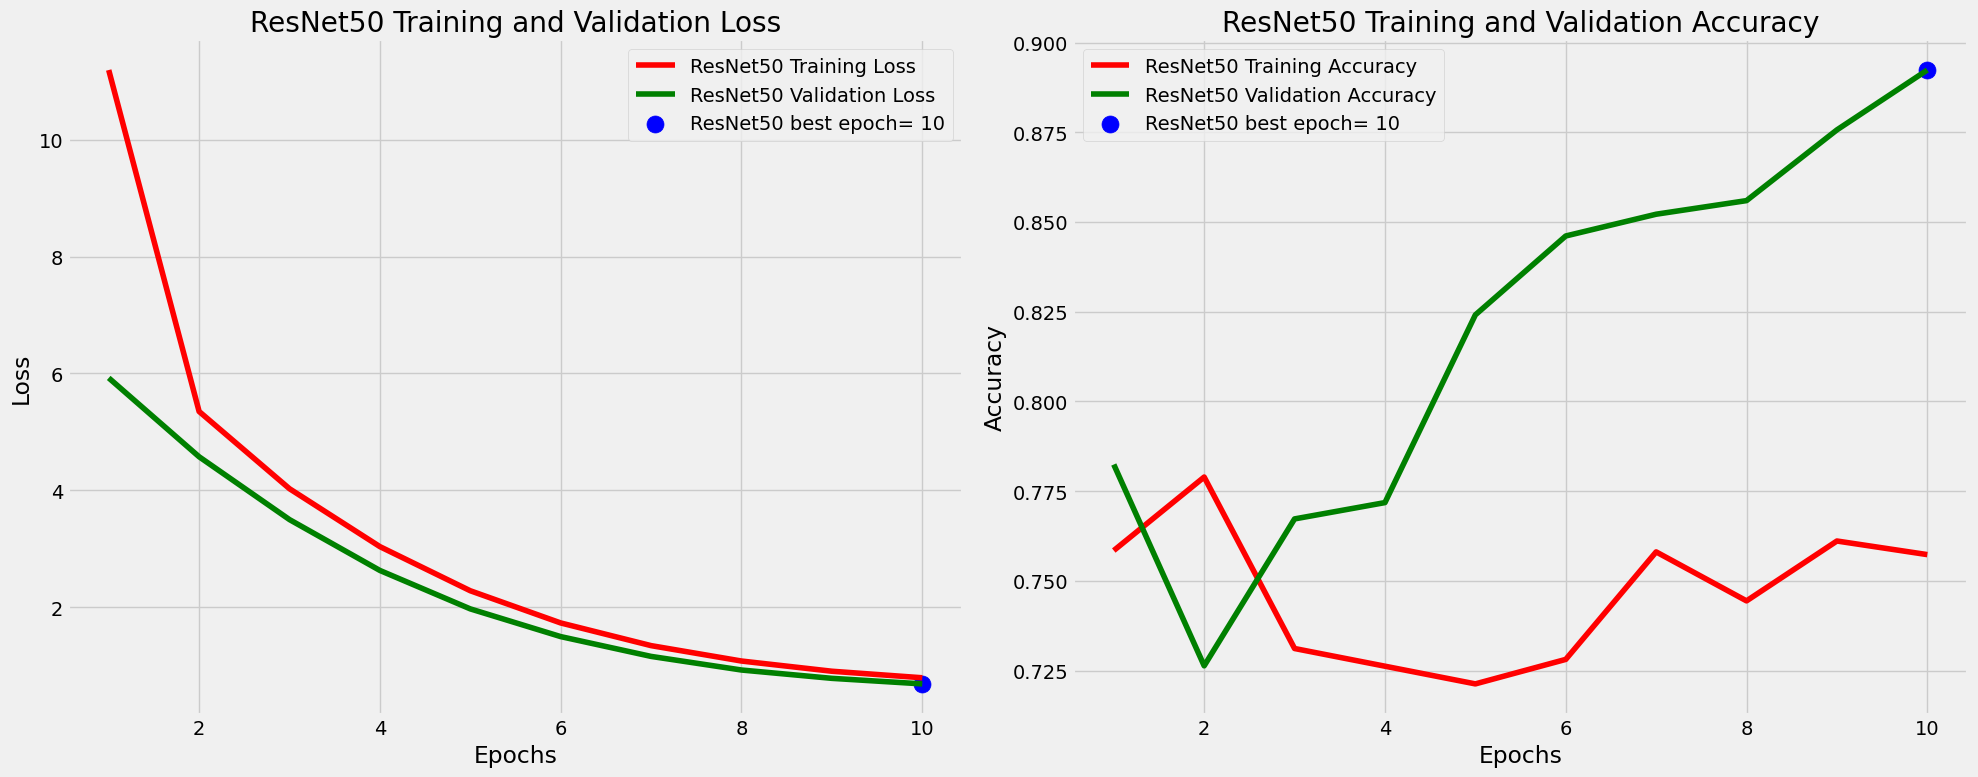

In [18]:
# Extract training and validation metrics from history
tr_acc_resnet = history_resnet.history['accuracy']
tr_loss_resnet = history_resnet.history['loss']
val_acc_resnet = history_resnet.history['val_accuracy']
val_loss_resnet = history_resnet.history['val_loss']

# Find best epochs and metrics
index_loss_resnet = np.argmin(val_loss_resnet)
val_lowest_resnet = val_loss_resnet[index_loss_resnet]
index_acc_resnet = np.argmax(val_acc_resnet)
acc_highest_resnet = val_acc_resnet[index_acc_resnet]

# Define epochs list
Epochs_resnet = [i+1 for i in range(len(tr_acc_resnet))]

# Define labels for best epochs
loss_label_resnet = f'ResNet50 best epoch= {str(index_loss_resnet + 1)}'
acc_label_resnet = f'ResNet50 best epoch= {str(index_acc_resnet + 1)}'

# Plot training history for ResNet50
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_resnet, tr_loss_resnet, 'r', label= 'ResNet50 Training Loss')
plt.plot(Epochs_resnet, val_loss_resnet, 'g', label= 'ResNet50 Validation Loss')
plt.scatter(index_loss_resnet + 1, val_lowest_resnet, s= 150, c= 'blue', label= loss_label_resnet)
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_resnet, tr_acc_resnet, 'r', label= 'ResNet50 Training Accuracy')
plt.plot(Epochs_resnet, val_acc_resnet, 'g', label= 'ResNet50 Validation Accuracy')
plt.scatter(index_acc_resnet + 1, acc_highest_resnet, s= 150, c= 'blue', label= acc_label_resnet)
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Evaluate Model**

In [19]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model_resnet on the training, validation, and test sets
train_score_resnet = model_resnet.evaluate(train_gen, steps=test_steps)
valid_score_resnet = model_resnet.evaluate(valid_gen, steps=test_steps)
test_score_resnet = model_resnet.evaluate(test_gen, steps=test_steps)

print("ResNet50 Train Loss: ", train_score_resnet[0])
print("ResNet50 Train Accuracy: ", train_score_resnet[1])
print('-' * 20)
print("ResNet50 Validation Loss: ", valid_score_resnet[0])
print("ResNet50 Validation Accuracy: ", valid_score_resnet[1])
print('-' * 20)
print("ResNet50 Test Loss: ", test_score_resnet[0])
print("ResNet50 Test Accuracy: ", test_score_resnet[1])


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8879 - loss: 0.6888  
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8830 - loss: 0.6887   
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8927 - loss: 0.6898  
ResNet50 Train Loss:  0.6895020008087158
ResNet50 Train Accuracy:  0.8873720169067383
--------------------
ResNet50 Validation Loss:  0.6890365481376648
ResNet50 Validation Accuracy:  0.8823975920677185
--------------------
ResNet50 Test Loss:  0.6896225214004517
ResNet50 Test Accuracy:  0.8923426866531372


**Predictions**

In [20]:
preds_resnet = model_resnet.predict(test_gen)
y_pred_resnet = np.argmax(preds_resnet, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step


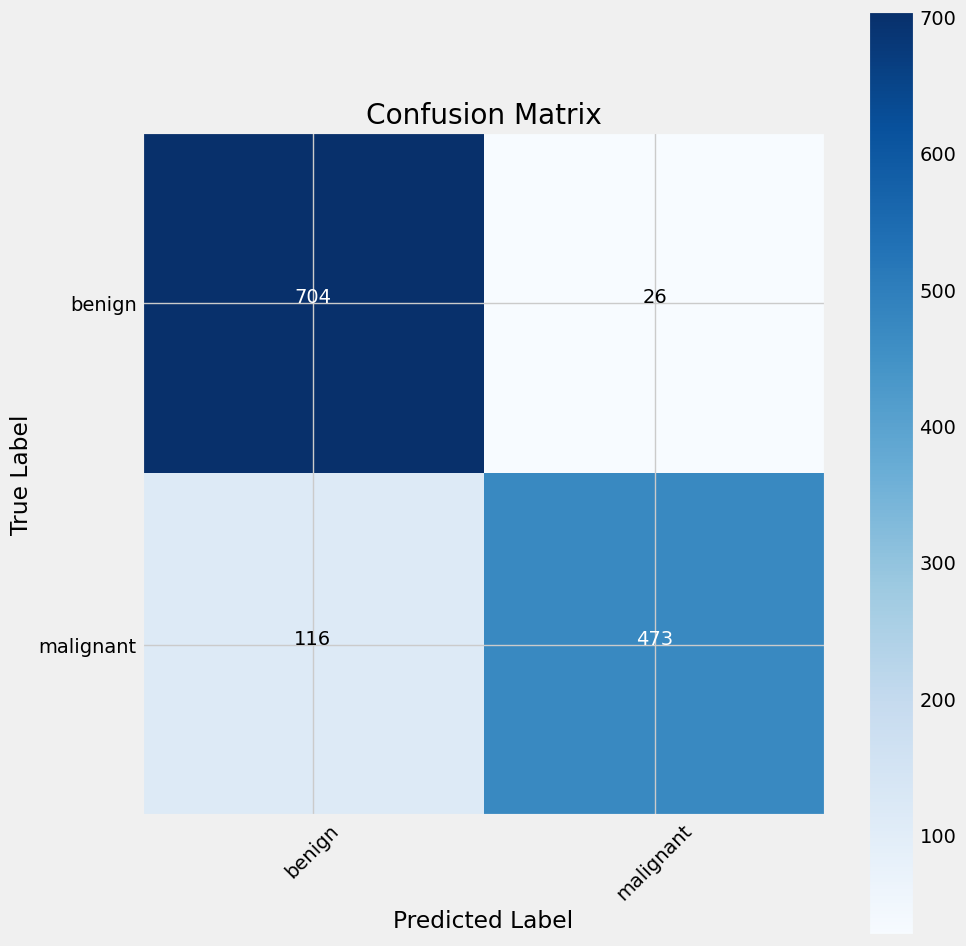

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred_resnet)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
print(classification_report(test_gen.classes, y_pred_resnet, target_names= classes))

              precision    recall  f1-score   support

      benign       0.86      0.96      0.91       730
   malignant       0.95      0.80      0.87       589

    accuracy                           0.89      1319
   macro avg       0.90      0.88      0.89      1319
weighted avg       0.90      0.89      0.89      1319



# **Modeling Using VGG19**

In [23]:
from tensorflow.keras.applications import VGG19

img_size_VGG = (224, 224)
channels_VGG = 3
img_shape_VGG = (img_size_VGG[0], img_size_VGG[1], channels_VGG)

# Number of classes in your dataset
class_count_VGG = len(list(train_gen.class_indices.keys()))

# Create pre-trained model (VGG19 from the VGG family)
base_model_VGG = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape_VGG,
    pooling='avg'  # Using average pooling to reduce spatial dimensions
)
base_model_VGG.trainable = False  # Freeze the base model weights

# Build the Sequential model
model_VGG = Sequential([
    base_model_VGG,
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.016), 
          activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006)),
    Dropout(0.45),
    Dense(class_count_VGG, activation='softmax')
])

# Compile the model
model_VGG.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model (this is necessary for defining the input shape)
model_VGG.build(input_shape=(None, *img_shape_VGG))

# Print model summary
model_VGG.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,158,274 (76.90 MB)

 Trainable params: 132,866 (519.01 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [24]:
tf.config.optimizer.set_jit(False)

In [25]:
history_VGG = model_VGG.fit( x=train_gen, epochs=10, verbose=1, validation_data=test_gen,validation_steps=None, shuffle=False)

Epoch 1/10


2024-09-19 06:12:14.838391: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-09-19 06:12:14.838452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-09-19 06:12:14.838467: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-09-19 06:12:14.838485: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-09-19 06:12:14.838497: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-09-19 06:12:14.838508: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-09-19 06:12:14.838520: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-09-19 06:12:14.838531: E external/local_xla/xla

163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7225 - loss: 12.7351

2024-09-19 06:12:32.536511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 5.04893, expected 4.24247
2024-09-19 06:12:32.536568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.99988, expected 6.19341
2024-09-19 06:12:32.536585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.949, expected 6.14253
2024-09-19 06:12:32.536603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.3455, expected 5.53903
2024-09-19 06:12:32.536617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.4062, expected 5.59973
2024-09-19 06:12:32.536628: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 6.93991, expected 6.13344
2024-09-19 06:12:32.536639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.95738, expected 5.15092
2024-09-19 06:12:32.5366

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7227 - loss: 12.7057

2024-09-19 06:12:45.375087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.2267, expected 3.60484
2024-09-19 06:12:45.375146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.85455, expected 4.23268
2024-09-19 06:12:45.375156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.28153, expected 3.65967
2024-09-19 06:12:45.375164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.91769, expected 4.29583
2024-09-19 06:12:45.375179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.93006, expected 4.3082
2024-09-19 06:12:45.375191: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.17726, expected 3.55539
2024-09-19 06:12:45.375204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.89416, expected 2.2723
2024-09-19 06:12:45.375217: E external/local_xla/xla/ser

165/165 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.7229 - loss: 12.6913 - val_accuracy: 0.7854 - val_loss: 33964.8984
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7649 - loss: 5.2395 - val_accuracy: 0.7210 - val_loss: 41074.2852
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7078 - loss: 3.4310 - val_accuracy: 0.6823 - val_loss: 51303.4297
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.6834 - loss: 2.6744 - val_accuracy: 0.6702 - val_loss: 58437.4766
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6403 - loss: 2.1065 - val_accuracy: 0.6702 - val_loss: 57300.6992
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6678 - loss: 1.6504 - val_accuracy: 0.6755 - val_loss: 51435.9805
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6760 - loss: 1.3303 - val_accuracy: 0.7233 - val_loss: 39901.9453
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.714

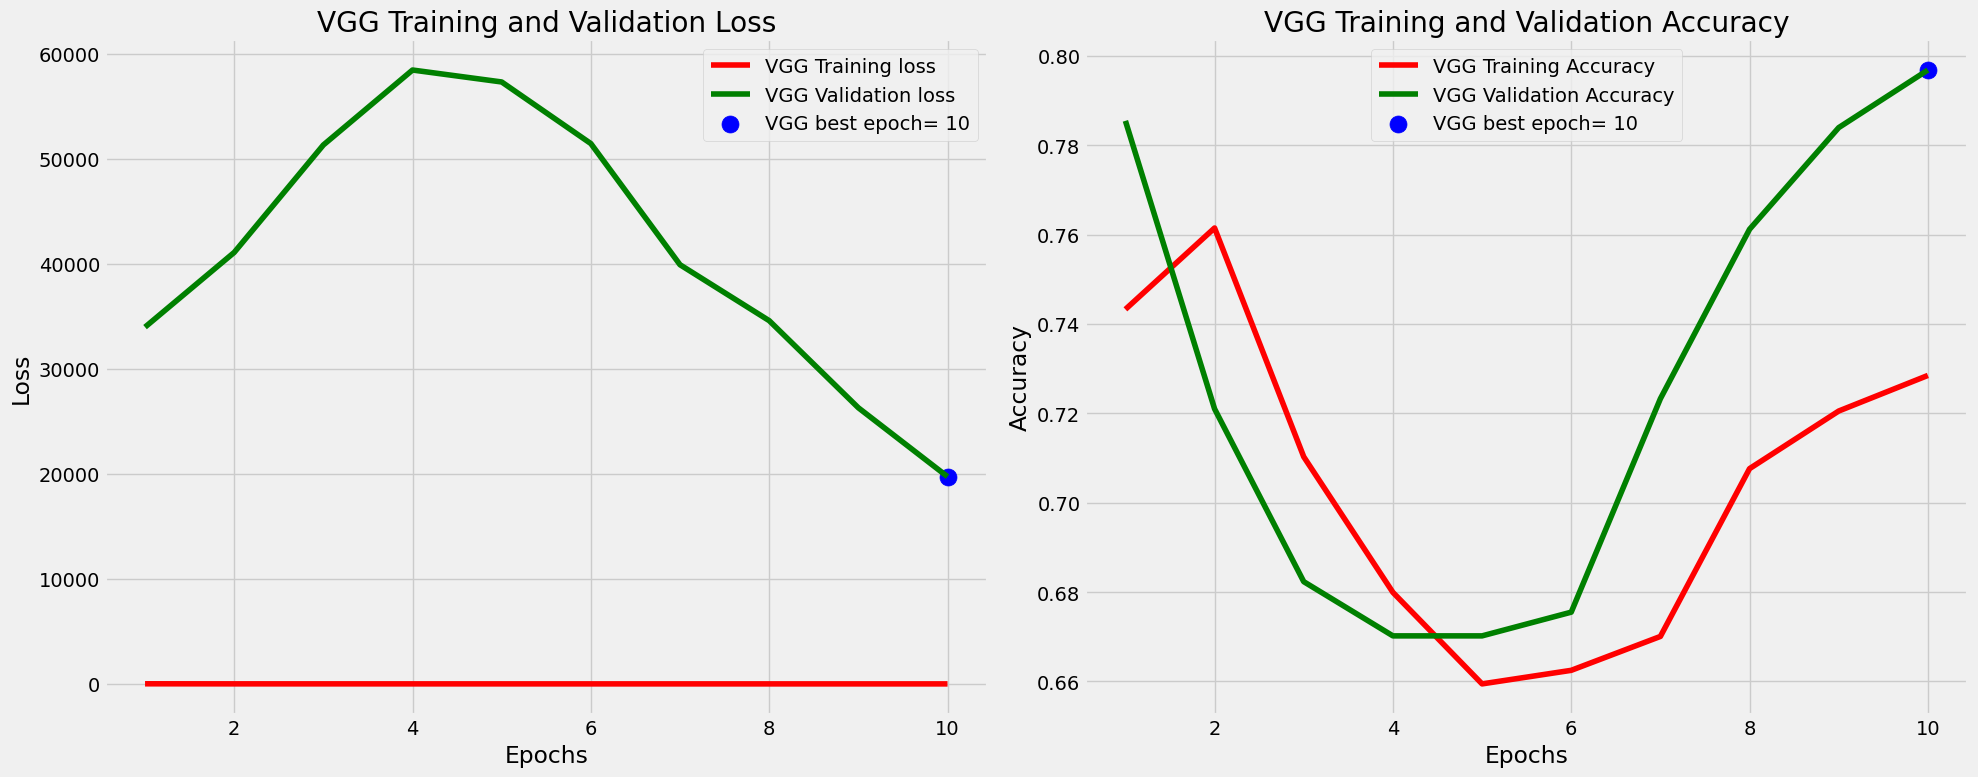

In [26]:
tr_acc_VGG = history_VGG.history['accuracy']
tr_loss_VGG = history_VGG.history['loss']
val_acc_VGG = history_VGG.history['val_accuracy']
val_loss_VGG = history_VGG.history['val_loss']

index_loss_VGG = np.argmin(val_loss_VGG)
val_lowest_VGG = val_loss_VGG[index_loss_VGG]
index_acc_VGG = np.argmax(val_acc_VGG)
acc_highest_VGG = val_acc_VGG[index_acc_VGG]

Epochs_VGG = [i+1 for i in range(len(tr_acc_VGG))]
loss_label_VGG = f'VGG best epoch= {str(index_loss_VGG + 1)}'
acc_label_VGG = f'VGG best epoch= {str(index_acc_VGG + 1)}'

# Plot training history for VGG
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_VGG, tr_loss_VGG, 'r', label= 'VGG Training loss')
plt.plot(Epochs_VGG, val_loss_VGG, 'g', label= 'VGG Validation loss')
plt.scatter(index_loss_VGG + 1, val_lowest_VGG, s= 150, c= 'blue', label= loss_label_VGG)
plt.title('VGG Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_VGG, tr_acc_VGG, 'r', label= 'VGG Training Accuracy')
plt.plot(Epochs_VGG, val_acc_VGG, 'g', label= 'VGG Validation Accuracy')
plt.scatter(index_acc_VGG + 1 , acc_highest_VGG, s= 150, c= 'blue', label= acc_label_VGG)
plt.title('VGG Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Evaluate Model**

In [27]:
ts_length_VGG = len(test_df)
test_batch_size_VGG = max(sorted([ts_length_VGG // n for n in range(1, ts_length_VGG + 1) if ts_length_VGG%n == 0 and ts_length_VGG/n <= 80]))
test_steps_VGG = ts_length_VGG // test_batch_size_VGG

train_score_VGG = model_VGG.evaluate(train_gen, steps=test_steps_VGG)
valid_score_VGG = model_VGG.evaluate(valid_gen, steps=test_steps_VGG)
test_score_VGG = model_VGG.evaluate(test_gen, steps=test_steps_VGG)

print("VGG Train Loss: ", train_score_VGG[0])
print("VGG Train Accuracy: ", train_score_VGG[1])
print('-' * 20)
print("VGG Validation Loss: ", valid_score_VGG[0])
print("VGG Validation Accuracy: ", valid_score_VGG[1])
print('-' * 20)
print("VGG Test Loss: ", test_score_VGG[0])
print("VGG Test Accuracy: ", test_score_VGG[1])


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8084 - loss: 0.7345  
  82/1319 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - accuracy: 0.8105 - loss: 0.7421

2024-09-19 06:14:38.054728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.64217, expected 2.7931
2024-09-19 06:14:38.054785: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.85027, expected 4.0012
2024-09-19 06:14:38.054804: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.44079, expected 3.59172
2024-09-19 06:14:38.054813: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.81156, expected 3.96248
2024-09-19 06:14:38.054821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.0588, expected 4.20973
2024-09-19 06:14:38.054828: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.43719, expected 3.58812
2024-09-19 06:14:38.054836: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.55385, expected 3.70478
2024-09-19 06:14:38.054844: E external/local_xla/xla/servi

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8167 - loss: 929.2854  
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7976 - loss: 18505.2930
VGG Train Loss:  0.7344369292259216
VGG Train Accuracy:  0.8096321821212769
--------------------
VGG Validation Loss:  990.8380126953125
VGG Validation Accuracy:  0.8171471953392029
--------------------
VGG Test Loss:  19731.94921875
VGG Test Accuracy:  0.7968157529830933


**Predictions**

In [28]:
preds_VGG = model_VGG.predict(test_gen)
y_pred_VGG = np.argmax(preds_VGG, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


# **Comparison**

In [29]:
# Summary of the results
print(f"{'Model':<15} {'Train Loss':<12} {'Train Accuracy':<15} {'Val Loss':<12} {'Val Accuracy':<15} {'Test Loss':<12} {'Test Accuracy':<15}")
print('-' * 90)

# VGG Results
print(f"{'VGG':<15} {train_score_VGG[0]:<12.4f} {train_score_VGG[1]:<15.4f} {valid_score_VGG[0]:<12.4f} {valid_score_VGG[1]:<15.4f} {test_score_VGG[0]:<12.4f} {test_score_VGG[1]:<15.4f}")

# ResNet50 Results
print(f"{'ResNet50':<15} {train_score_resnet[0]:<12.4f} {train_score_resnet[1]:<15.4f} {valid_score_resnet[0]:<12.4f} {valid_score_resnet[1]:<15.4f} {test_score_resnet[0]:<12.4f} {test_score_resnet[1]:<15.4f}")

# EfficientNetB3
print(f"{'EfficientNetB3':<15} {train_score[0]:<12.4f} {train_score[1]:<15.4f} {valid_score[0]:<12.4f} {valid_score[1]:<15.4f} {test_score[0]:<12.4f} {test_score[1]:<15.4f}")


Model           Train Loss   Train Accuracy  Val Loss     Val Accuracy    Test Loss    Test Accuracy  
------------------------------------------------------------------------------------------
VGG             0.7344       0.8096          990.8380     0.8171          19731.9492   0.7968         
ResNet50        0.6895       0.8874          0.6890       0.8824          0.6896       0.8923         
EfficientNetB3  0.6626       0.8495          0.6570       0.8520          0.6678       0.8469         
